In [8]:
import pandas as pd
from pathlib import Path

# 1) Indlæs de to (eller flere) metrics-filer
paths = [
    r"E:\Speciale - Results\Final_RR_alignment\rr_peak_metrics_P01-05-29_6methodes.csv",
    r"E:\Speciale - Results\Final_RR_alignment\rr_peak_metrics_P02-03-04_6methodes.csv",
    r"E:\Speciale - Results\Final_RR_alignment\rr_peak_metrics_P06-07-08-09-10_6methodes.csv",
]
df_metrics = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)

# Tjek at de kolonner du forventer er der
df_metrics.columns


Index(['n_common', 'rr_mae_ms', 'rr_rmse_ms', 'rr_corr', 'mean_hr_ref_bpm',
       'mean_hr_test_bpm', 'mean_hr_diff_bpm', 'patient_id', 'recording_id',
       'algo_id', 'trim_label', 'n_rr_labview_total', 'n_rr_python_total',
       'n_rr_matched', 'best_delta_s', 'tdms_start_epoch',
       'labview_first_r_epoch', 'python_first_r_epoch',
       'labview_first_r_rel_s', 'python_first_r_rel_s', 'first_r_rel_diff_s',
       'raw_tdms_path', 'raw_lvm_path', 'n_peaks_labview_total',
       'n_peaks_python_total', 'n_peaks_tp', 'n_peaks_fp', 'n_peaks_fn',
       'peak_sens', 'peak_ppv', 'peak_f1', 'method'],
      dtype='object')

In [9]:
# Vælg de vigtigste performance-mål
cols_perf = ["rr_mae_ms", "rr_rmse_ms", "rr_corr",
             "peak_sens", "peak_ppv", "peak_f1"]

summary_methods = (
    df_metrics
    .groupby("algo_id")[cols_perf]
    .agg(["median", "mean", "std"])
    .sort_values(("rr_mae_ms", "median"))
)

summary_methods


rr_mae_ms                             rr_rmse_ms  \
                    median          mean           std     median   
algo_id                                                             
neurokit          1.900755  4.608075e+00  6.133356e+00  16.790707   
emrich2023        2.043688  3.783810e+00  4.026240e+00  15.348657   
nabian2018        5.079893  1.077296e+01  1.269834e+01  49.049421   
elgendi2010       6.190446  1.347803e+01  2.688856e+01  23.562087   
hamilton2002      8.456118  1.401795e+06  5.779703e+06  29.360846   
pantompkins1985  30.784796  1.740375e+04  6.687969e+04  75.792348   

                                              rr_corr                      \
                         mean           std    median      mean       std   
algo_id                                                                     
neurokit         8.062840e+01  1.398893e+02  0.988088  0.828666  0.330755   
emrich2023       4.920606e+02  1.133061e+03  0.994728  0.781946  0.399277   
nabian2018       6.049198e+01  3.589478e+01  0.903833  0.845552  0.161139   
elgendi2010      3.914052e+01  4.276550e+01  0.971697  0.879469  0.272857   
hamilton2002     1.806923e+06  7.447921e+06  0.942380  0.717087  0.373211   
pantompkins1985  7.918167e+04  2.764280e+05  0.639717  0.530501  0.445019   

                peak_sens                      peak_ppv                      \
                   median      mean       std    median      mean       std   
algo_id                                                                       
neurokit         0.000225  0.387589  0.499837  0.000231  0.387547  0.499780   
emrich2023       0.000052  0.263470  0.440360  0.000055  0.293866  0.469185   
nabian2018       0.985264  0.665052  0.471090  0.986848  0.665452  0.472275   
elgendi2010      0.002028  0.016247  0.046382  0.002026  0.012937  0.033314   
hamilton2002     0.000048  0.027233  0.080506  0.000054  0.031644  0.091232   
pantompkins1985  0.000267  0.055773  0.131495  0.016283  0.135886  0.184085   

                  peak_f1                      
                   median      mean       std  
algo_id                                        
neurokit         0.000249  0.410365  0.505449  
emrich2023       0.000055  0.285370  0.456708  
nabian2018       0.983254  0.665192  0.471603  
elgendi2010      0.002027  0.014322  0.038722  
hamilton2002     0.000079  0.036583  0.094840  
pantompkins1985  0.001401  0.074457  0.146658

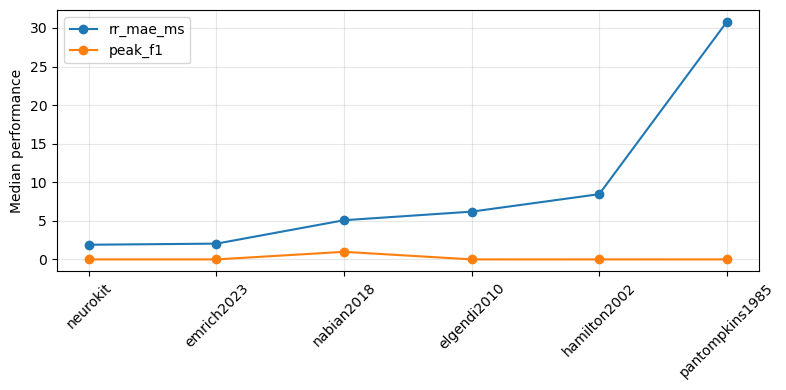

In [3]:
import matplotlib.pyplot as plt

order = summary_methods.index.tolist()  # rækkefølge efter MAE

plt.figure(figsize=(8,4))
for metric in ["rr_mae_ms", "peak_f1"]:
    plt.plot(
        order,
        summary_methods[(metric, "median")].values,
        marker="o",
        label=metric,
    )
plt.xticks(rotation=45)
plt.ylabel("Median performance")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
df_q = pd.read_csv(
    r"E:\Speciale - Results\Datastruct\_analysis\study2\recording_quality_overview.csv"
)

# Behold kun de kolonner vi skal bruge nu
cols_q = [
    "patient_id", "recording_id",
    "quality_label",
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "hf_ratio",
    "qrs_power_ratio",
]
df_q_small = df_q[cols_q]

# Merge: én række per (patient, recording, algo_id)
df_all = df_metrics.merge(
    df_q_small,
    on=["patient_id", "recording_id"],
    how="left",
)

# Fx: metode-performance opdelt efter kvalitet-label
by_quality = (
    df_all
    .groupby(["algo_id", "quality_label"])[["rr_mae_ms", "peak_f1"]]
    .median()
    .reset_index()
)

by_quality


,algo_id,quality_label,rr_mae_ms,peak_f1
0,elgendi2010,good,5.131296,0.001760
1,emrich2023,good,1.976012,0.000055
2,hamilton2002,good,7.014841,0.000066
3,nabian2018,good,4.734336,0.986051
4,neurokit,good,1.751374,0.000228
5,pantompkins1985,good,30.663575,0.000608


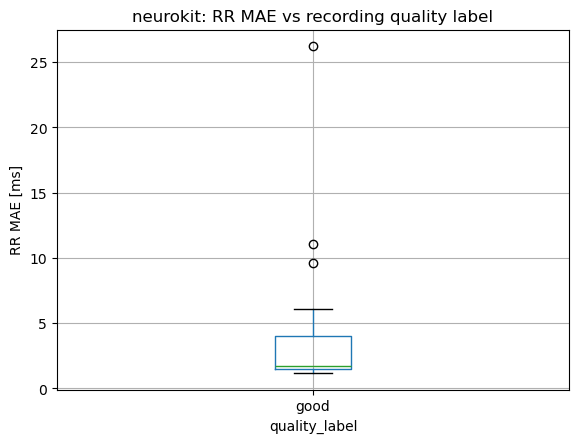

In [5]:
algo = "neurokit"
subset = df_all[df_all["algo_id"] == algo]

subset.boxplot(column="rr_mae_ms", by="quality_label")
plt.title(f"{algo}: RR MAE vs recording quality label")
plt.suptitle("")
plt.ylabel("RR MAE [ms]")
plt.show()


In [10]:
df_win = pd.read_csv(
    r"E:\Speciale - Results\Datastruct\_analysis\study2\window_quality_baseline_vs_seizure.csv"
)
df_win.columns
# forventet noget i stil med:
# ['window_idx', 'win_start_s', 'win_end_s',
#  'std', 'range', 'diff_abs_med',
#  'is_flatline', 'is_noiseburst', 'is_clipping', ...]


Index(['recording_uid', 'patient_id', 'recording_id', 'window_idx',
       'win_start_s', 'win_end_s', 'context', 'std', 'range', 'diff_abs_med',
       'is_flatline', 'is_noiseburst', 'is_clipping'],
      dtype='object')

In [42]:

df_rec = pd.read_csv(r"E:\Speciale - Results\Datastruct\recordings_index.csv")
print(df_rec.columns)
df_seiz = pd.read_csv(r"E:\Speciale - Results\Datastruct\seizure_events.csv")
df_seiz.head()
print(df_seiz.columns)

Index(['recording_uid', 'patient_id', 'enrollment_id', 'recording_id',
       'tdms_path', 'annotation_source', 'recording_start', 'recording_end',
       'rec_duration_s', 'fs'],
      dtype='object')
Index(['recording_uid', 'patient_id', 'enrollment_id', 'recording_id',
       'seizure_id', 't0', 't1', 'duration_s', 'absolute_start',
       'absolute_end', 't0_video', 't1_video', 'absolute_start_video',
       'absolute_end_video', 't0_clinical', 't1_clinical',
       'absolute_start_clinical', 'absolute_end_clinical'],
      dtype='object')


In [47]:
import pandas as pd

def attach_seizure_flag_to_windows(df_win_all, df_rec, df_seiz):
    # 1) Hent recording-start ind på vinduerne
    df_meta = df_rec[["patient_id", "recording_id", "recording_start"]].copy()
    df_meta["recording_start"] = pd.to_datetime(df_meta["recording_start"])
    df_meta = df_meta.rename(columns={"recording_start": "absolute_start"})

    df_win = df_win_all.merge(
        df_meta,
        on=["patient_id", "recording_id"],
        how="left",
    )

    # 2) Absolutte start/slut-tidspunkter for hvert vindue
    df_win["win_abs_start"] = df_win["absolute_start"] + pd.to_timedelta(
        df_win["win_start_s"], unit="s"
    )
    df_win["win_abs_end"] = df_win["absolute_start"] + pd.to_timedelta(
        df_win["win_end_s"], unit="s"
    )

    # 3) Flag seizure-vinduer pr. (patient_id, recording_id)
    def flag_group(g):
        pid, rid = g.name
        seiz = df_seiz[
            (df_seiz["patient_id"] == pid)
            & (df_seiz["recording_id"] == rid)
        ]

        if seiz.empty:
            g["is_seizure_window"] = False
            return g

        # sørg for datetime
        seiz_start = pd.to_datetime(seiz["absolute_start"])
        seiz_end   = pd.to_datetime(seiz["absolute_end"])

        intervals = pd.IntervalIndex.from_arrays(
            seiz_start, seiz_end, closed="both"
        )

        def overlaps_any(row):
            win_int = pd.Interval(row["win_abs_start"], row["win_abs_end"], closed="both")
            return intervals.overlaps(win_int).any()

        g["is_seizure_window"] = g.apply(overlaps_any, axis=1)
        return g

    df_win = (
        df_win
        .groupby(["patient_id", "recording_id"], group_keys=False)
        .apply(flag_group)
    )

    return df_win

df_win_with_seiz = attach_seizure_flag_to_windows(df_win_all, df_rec, df_seiz)


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_15748\3165409601.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(flag_group)


In [50]:
print(df_win_with_seiz["is_seizure_window"].value_counts())
df_win_with_seiz[df_win_with_seiz["is_seizure_window"]].head()


is_seizure_window
False    19108
True         5
Name: count, dtype: int64


,recording_uid,patient_id,recording_id,window_idx,win_start_s,win_end_s,context,std,range,diff_abs_med,...,is_clipping,nk_quality,ours_bad,nk_bad,nk_averageQRS,nk_zhao2018,absolute_start,win_abs_start,win_abs_end,is_seizure_window
13018,0,1,1,13018,130180.0,130190.0,baseline,171.836444,1421.573947,1.146536,...,False,0.999425,False,False,0.629801,Unacceptable,2016-02-22 11:04:14,2016-02-23 23:13:54,2016-02-23 23:14:04,True
13019,0,1,1,13019,130190.0,130200.0,seizure,263.091725,2521.318965,3.036480,...,False,0.994274,False,True,0.488667,Unacceptable,2016-02-22 11:04:14,2016-02-23 23:14:04,2016-02-23 23:14:14,True
13020,0,1,1,13020,130200.0,130210.0,seizure,422.585767,4130.576411,14.986696,...,False,0.987704,False,True,0.657372,Unacceptable,2016-02-22 11:04:14,2016-02-23 23:14:14,2016-02-23 23:14:24,True
13021,0,1,1,13021,130210.0,130220.0,seizure,273.905774,2108.079310,3.789459,...,False,0.975698,False,True,0.587901,Unacceptable,2016-02-22 11:04:14,2016-02-23 23:14:24,2016-02-23 23:14:34,True
13022,0,1,1,13022,130220.0,130230.0,seizure,263.741980,2450.174040,3.051881,...,False,0.976990,False,True,0.741725,Unacceptable,2016-02-22 11:04:14,2016-02-23 23:14:34,2016-02-23 23:14:44,True


In [51]:
import pandas as pd

def attach_seizure_flag_to_windows(df_win_all, df_rec, df_seiz):
    # 1) Hent recording-start ind på vinduerne
    df_meta = df_rec[["patient_id", "recording_id", "recording_start"]].copy()
    df_meta["recording_start"] = pd.to_datetime(df_meta["recording_start"])
    df_meta = df_meta.rename(columns={"recording_start": "absolute_start"})

    df_win = df_win_all.merge(
        df_meta,
        on=["patient_id", "recording_id"],
        how="left",
    )

    # 2) Absolutte start/slut-tidspunkter for hvert vindue
    df_win["win_abs_start"] = df_win["absolute_start"] + pd.to_timedelta(
        df_win["win_start_s"], unit="s"
    )
    df_win["win_abs_end"] = df_win["absolute_start"] + pd.to_timedelta(
        df_win["win_end_s"], unit="s"
    )

    # 3) Flag seizure-vinduer pr. (patient_id, recording_id)
    def flag_group(g):
        pid, rid = g.name
        seiz = df_seiz[
            (df_seiz["patient_id"] == pid)
            & (df_seiz["recording_id"] == rid)
        ]

        if seiz.empty:
            g["is_seizure_window"] = False
            return g

        seiz_start = pd.to_datetime(seiz["absolute_start"])
        seiz_end   = pd.to_datetime(seiz["absolute_end"])

        intervals = pd.IntervalIndex.from_arrays(
            seiz_start, seiz_end, closed="both"
        )

        def overlaps_any(row):
            win_int = pd.Interval(row["win_abs_start"], row["win_abs_end"], closed="both")
            return intervals.overlaps(win_int).any()

        g["is_seizure_window"] = g.apply(overlaps_any, axis=1)
        return g

    df_win = (
        df_win
        .groupby(["patient_id", "recording_id"], group_keys=False)
        .apply(flag_group)
    )

    return df_win


# Kør for hele datasættet:
df_win_all = attach_seizure_flag_to_windows(df_win_all, df_rec, df_seiz)


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_15748\567280218.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(flag_group)


is_seizure_window
False    19108
True         5
Name: count, dtype: int64

In [53]:
df_win_all.columns

Index(['recording_uid', 'patient_id', 'recording_id', 'window_idx',
       'win_start_s', 'win_end_s', 'context', 'std', 'range', 'diff_abs_med',
       'is_flatline', 'is_noiseburst', 'is_clipping', 'nk_quality', 'ours_bad',
       'nk_bad', 'nk_averageQRS', 'nk_zhao2018', 'absolute_start',
       'win_abs_start', 'win_abs_end', 'is_seizure_window'],
      dtype='object')

In [54]:
df_win_all.shape

(19113, 22)

In [ ]:
df_win_with_seiz["is_seizure_window"].value_counts()

# og noget ala:
df_win_with_seiz.groupby("is_seizure_window")[["std", "range", "ours_bad", "nk_averageQRS"]].describe()


In [16]:
import numpy as np
import neurokit2 as nk
from src.hrv_epatch.io.tdms import load_tdms_from_path

# Test på én recording / ét vindue
uid = "P01_R01"

# 1) hent rå signal + fs
tdms_path = df_rec_index[
    (df_rec_index['patient_id'] == int(uid.split('_')[0][1:])) &
    (df_rec_index['recording_id'] == int(uid.split('_')[1][1:]))
]['tdms_path'].values[0]
sig, meta = load_tdms_from_path(tdms_path)
fs = meta.fs

# 2) kør clean + SQI på hele signalet
ecg_clean = nk.ecg_clean(sig, sampling_rate=fs, method="neurokit")
sqi_series = nk.ecg_quality(ecg_clean, sampling_rate=fs)  # default Zhao/Zhang

sqi_series = np.asarray(sqi_series)

# 3) gennemsnit SQI inden for hvert 10s-vindue
win_s = 10
win_samples = int(win_s * fs)

n_win = len(sig) // win_samples
sqi_win = []
for i in range(n_win):
    seg = sqi_series[i*win_samples:(i+1)*win_samples]
    sqi_win.append(seg.mean())

df_win = df_win.iloc[:n_win].copy()
df_win["nk_quality"] = sqi_win


In [17]:
# Vores regler (du kan tilpasse til de thresholds vi ender på)
df_win["ours_bad"] = (
    df_win["is_noiseburst"] |
    df_win["is_flatline"] |
    df_win["is_clipping"]
)

# NeuroKit "bad" – fx under 0.9 eller kvantilbaseret
nk_thresh = df_win["nk_quality"].quantile(0.1)  # nederste 10 %
df_win["nk_bad"] = df_win["nk_quality"] < nk_thresh

# Sammenlign som krydstabel
pd.crosstab(df_win["ours_bad"], df_win["nk_bad"])


nk_bad,False,True
ours_bad,,
False,17193,1891
True,8,21


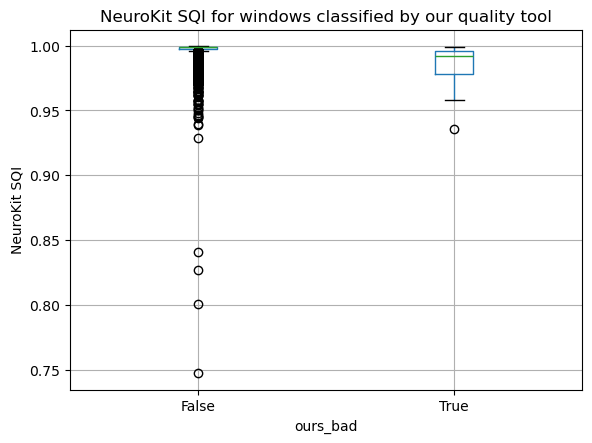

In [18]:
df_win.boxplot(column="nk_quality", by="ours_bad")
plt.title("NeuroKit SQI for windows classified by our quality tool")
plt.suptitle("")
plt.ylabel("NeuroKit SQI")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk

def compute_neurokit_sqi_per_window(
    sig: np.ndarray,
    fs: float,
    win_s: float = 10.0,
    methods=("templatematch", "averageQRS", "zhao2018"),
):
    """
    Robust per-vindue beregning af NeuroKit-SQI.

    Hvis NeuroKit fejler i et vindue (fx pga bug i ecg_quality),
    gemmes NaN for den pågældende metode.
    """
    sig = np.asarray(sig, float).ravel()
    win_n = int(win_s * fs)
    n_win = len(sig) // win_n

    rows = []
    for w in range(n_win):
        s = w * win_n
        e = s + win_n
        seg = sig[s:e]

        # Clean pr. vindue
        seg_clean = nk.ecg_clean(seg, sampling_rate=fs, method="neurokit")

        row = {
            "window_idx": w,
            "win_start_s": s / fs,
            "win_end_s": e / fs,
        }

        for m in methods:
            try:
                # nogle versioner er lidt sarte mht. 'approach', så lad default stå
                q = nk.ecg_quality(seg_clean, sampling_rate=fs, method=m)
            except Exception as err:
                print(f"[SQI] Fejl i vindue {w}, method='{m}': {err}")
                row[f"nk_{m}"] = np.nan
                continue

            # averageQRS → tal/array, zhao2018 → tekstklassifikation
            if isinstance(q, (list, np.ndarray, pd.Series)):
                row[f"nk_{m}"] = float(np.mean(q))
            else:
                row[f"nk_{m}"] = q

        rows.append(row)

    return pd.DataFrame(rows)


In [24]:
# vælg den recording du vil arbejde på
# Test på én recording / ét vindue
uid = "P01_R01"

# 1) hent rå signal + fs
tdms_path = df_rec_index[
    (df_rec_index['patient_id'] == int(uid.split('_')[0][1:])) &
    (df_rec_index['recording_id'] == int(uid.split('_')[1][1:]))
]['tdms_path'].values[0]
sig, meta = load_tdms_from_path(tdms_path)
fs = meta.fs

df_nk_sqi = compute_neurokit_sqi_per_window(sig, fs, win_s=10.0)

df_win_all = (
    df_win
    .merge(df_nk_sqi, on=["window_idx", "win_start_s", "win_end_s"], how="left")
)



c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\kvjkv\anaconda3\envs\mast\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


[SQI] Fejl i vindue 19106, method='averageQRS': cannot convert float NaN to integer
[SQI] Fejl i vindue 19107, method='averageQRS': cannot convert float NaN to integer
[SQI] Fejl i vindue 19111, method='averageQRS': cannot convert float NaN to integer


In [31]:
df_win_all.columns


Index(['recording_uid', 'patient_id', 'recording_id', 'window_idx',
       'win_start_s', 'win_end_s', 'context', 'std', 'range', 'diff_abs_med',
       'is_flatline', 'is_noiseburst', 'is_clipping', 'nk_quality', 'ours_bad',
       'nk_bad', 'nk_averageQRS', 'nk_zhao2018'],
      dtype='object')

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sqi_window_overview(
    sig,
    fs,
    df_win_all,
    start_s,
    duration_s=60,
    win_s=10.0,
    ours_col="ours_bad",          # bool eller 0/1 pr. vindue
    nk_col="nk_averageQRS",       # numeric [0,1]
    zhao_col="nk_zhao2018",       # tekst
):
    sig = np.asarray(sig, float).ravel()
    start_idx = int(start_s * fs)
    end_idx = int((start_s + duration_s) * fs)
    t = np.arange(start_idx, end_idx) / fs

    seg_raw = sig[start_idx:end_idx]
    seg_clean = nk.ecg_clean(seg_raw, sampling_rate=fs, method="neurokit")

    # vinduer der falder i dette interval
    win = df_win_all[
        (df_win_all["win_start_s"] >= start_s)
        & (df_win_all["win_end_s"] <= start_s + duration_s)
    ].copy()

    # x-koordinater midt i hvert vindue
    win["t_mid"] = (win["win_start_s"] + win["win_end_s"]) / 2

    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    ax1, ax2, ax3 = axes

    # --- 1) Rå signal ---
    ax1.plot(t, seg_raw)
    ax1.set_ylabel("Raw [a.u.]")
    ax1.set_title("Raw ECG with window shading")

    # markér vinduer og zhao2018-kategorier
    for _, r in win.iterrows():
        color = {
            "Unacceptable": (1, 0.8, 0.8),
            "Barely acceptable": (1, 1, 0.8),
            "Excellent": (0.8, 1, 0.8),
        }.get(r.get(zhao_col, ""), (0.9, 0.9, 0.9))
        ax1.axvspan(r["win_start_s"], r["win_end_s"], color=color, alpha=0.3)

    # --- 2) Cleaned signal ---
    ax2.plot(t, seg_clean)
    ax2.set_ylabel("Cleaned [a.u.]")
    ax2.set_title("NeuroKit-cleaned ECG (method='neurokit')")

    # --- 3) SQI-kurver ---
    # Vores egen: tegn 0/1 som punkter
    if ours_col in win.columns:
        y_ours = win[ours_col].astype(float)
        ax3.scatter(win["t_mid"], y_ours, label="Our quality flag (0/1)", s=20)

    # NeuroKit averageQRS
    if nk_col in win.columns:
        ax3.plot(win["t_mid"], win[nk_col], "-o", label="NeuroKit averageQRS", markersize=4)

    ax3.set_ylim(-0.1, 1.1)
    ax3.set_ylabel("SQI")
    ax3.set_xlabel("Time [s]")
    ax3.set_title("Window-level SQI (our tool vs NeuroKit)")
    ax3.grid(alpha=0.3)
    ax3.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


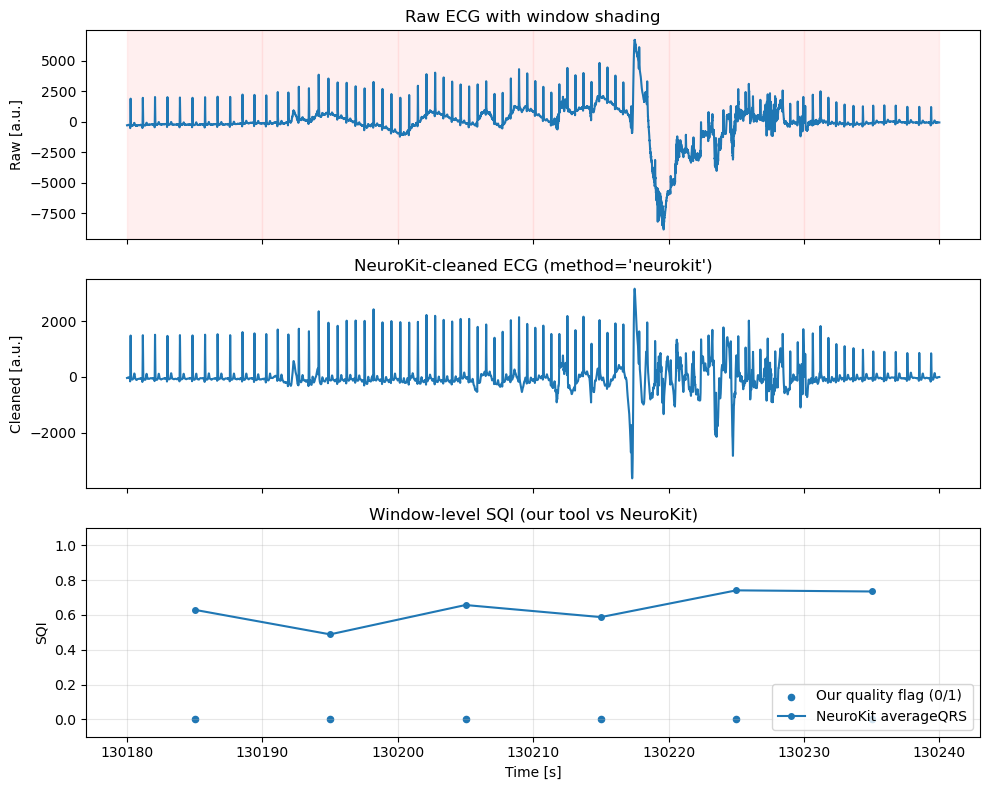

In [39]:
row = df_nk_sqi.iloc[0]  # vælg relevant recording

# fx 60 s omkring et seizure eller et støjområde
plot_sqi_window_overview(
    sig=sig,
    fs=fs,
    df_win_all=df_win_all,
    start_s=130180,            # tilpas til noget interessant
    duration_s=60,
)


In [40]:
t0, t1 = 130180, 130240  # tilpas hvis du brugte et andet interval

cols_to_show = [
    "window_idx",
    "win_start_s", "win_end_s",
    "std", "range", "diff_abs_med",
    "is_flatline", "is_noiseburst", "is_clipping",
    "ours_bad",
    "nk_averageQRS",
    'nk_averageQRS', 
    'nk_zhao2018'
]

df_debug = (
    df_win_all
    .query("win_start_s >= @t0 and win_end_s <= @t1")
    [cols_to_show]
    .sort_values("win_start_s")
)

print(df_debug.to_string(index=False))


 window_idx  win_start_s  win_end_s        std       range  diff_abs_med  is_flatline  is_noiseburst  is_clipping  ours_bad  nk_averageQRS  nk_averageQRS  nk_zhao2018
      13018     130180.0   130190.0 171.836444 1421.573947      1.146536        False          False        False     False       0.629801       0.629801 Unacceptable
      13019     130190.0   130200.0 263.091725 2521.318965      3.036480        False          False        False     False       0.488667       0.488667 Unacceptable
      13020     130200.0   130210.0 422.585767 4130.576411     14.986696        False          False        False     False       0.657372       0.657372 Unacceptable
      13021     130210.0   130220.0 273.905774 2108.079310      3.789459        False          False        False     False       0.587901       0.587901 Unacceptable
      13022     130220.0   130230.0 263.741980 2450.174040      3.051881        False          False        False     False       0.741725       0.741725 Unacceptabl

In [38]:
bad_segments = df_win_all[df_win_all["ours_bad"] == True]
print(bad_segments.shape)
bad_segments

(29, 18)


,recording_uid,patient_id,recording_id,window_idx,win_start_s,win_end_s,context,std,range,diff_abs_med,is_flatline,is_noiseburst,is_clipping,nk_quality,ours_bad,nk_bad,nk_averageQRS,nk_zhao2018
0,0,1,1,0,0.0,10.0,baseline,4845.317329,52274.015691,30.211861,False,True,False,0.960794,True,True,0.677009,Unacceptable
4,0,1,1,4,40.0,50.0,baseline,1476.413101,14641.533797,3.095491,False,True,False,0.984257,True,True,0.563241,Unacceptable
716,0,1,1,716,7160.0,7170.0,baseline,1969.780948,20690.415943,15.999272,False,True,False,0.996663,True,False,0.552521,Unacceptable
719,0,1,1,719,7190.0,7200.0,baseline,1178.497818,8883.048417,6.900255,False,True,False,0.987425,True,True,0.469382,Unacceptable
720,0,1,1,720,7200.0,7210.0,baseline,1380.170056,10672.689821,17.787554,False,True,False,0.982253,True,True,0.615728,Unacceptable
721,0,1,1,721,7210.0,7220.0,baseline,1379.278834,9511.430477,24.541755,False,True,False,0.965161,True,True,0.583830,Unacceptable
722,0,1,1,722,7220.0,7230.0,baseline,1191.785060,10961.364482,17.061695,False,True,False,0.935796,True,True,0.628542,Unacceptable
727,0,1,1,727,7270.0,7280.0,baseline,1321.926216,8917.307181,20.661543,False,True,False,0.957965,True,True,0.610956,Unacceptable
834,0,1,1,834,8340.0,8350.0,baseline,2480.087548,34206.670611,3.555948,False,True,False,0.998021,True,False,0.498531,Unacceptable
835,0,1,1,835,8350.0,8360.0,baseline,1158.375640,13659.589409,9.796512,False,True,False,0.978299,True,True,0.728840,Unacceptable


In [28]:
def plot_sqi_agreement(df_win_all, ours_col="ours_bad", nk_col="nk_averageQRS"):
    df = df_win_all.dropna(subset=[ours_col, nk_col]).copy()
    df[ours_col] = df[ours_col].astype(bool)

    plt.figure(figsize=(5,4))
    df.boxplot(column=nk_col, by=ours_col)
    plt.suptitle("")
    plt.title("NeuroKit averageQRS vs our quality flag")
    plt.xlabel("ours_bad")
    plt.ylabel("NeuroKit SQI")
    plt.grid(alpha=0.3)
    plt.show()

    ctab = pd.crosstab(df[ours_col], df[nk_col] < 0.9)  # fx threshold 0.9
    ctab.columns = ["NK_good(>=0.9)", "NK_bad(<0.9)"]
    print(ctab)


<Figure size 500x400 with 0 Axes>

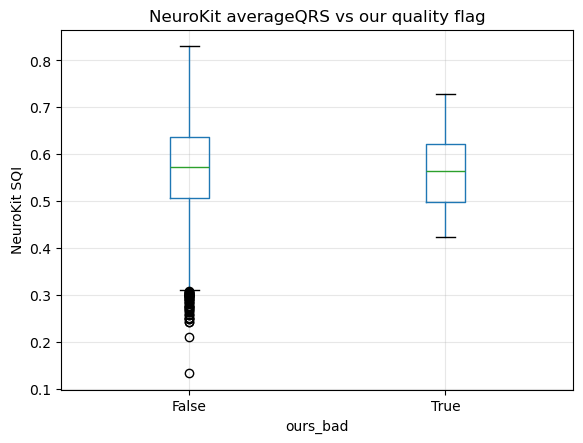

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [29]:
plot_sqi_agreement(df_win_all)


In [ ]:
methods_sqi = ["templatematch", "averageQRS", "zhao2018"]  # udvid evt. hvis NeuroKit tilføjer flere
df_nk_sqi = compute_neurokit_sqi_per_window(sig, fs, win_s=10.0, methods=methods_sqi)
